# Exercise 7

# Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

C:\Users\c_pal\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read the data and set "datetime" as the index
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [6]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [7]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

Hay simetria entre la renta entre semana que los fines de semana, ahora bien teniendo en cuenta que el fin de semana son solo 2 días, la concentración por hora puede ser más alta.

In [8]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Entre las 5 y las 6 de la tarde son las horas donde más se rentan bicicletas

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

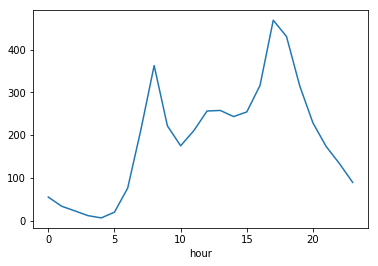

In [9]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

In [11]:
bikes_1= bikes[bikes['workingday']==1]
bikes_0= bikes[bikes['workingday']==0]

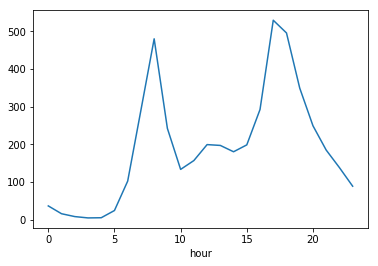

In [12]:
# mean rentals for each value of "hour"
bikes_1.groupby('hour').total.mean().plot()

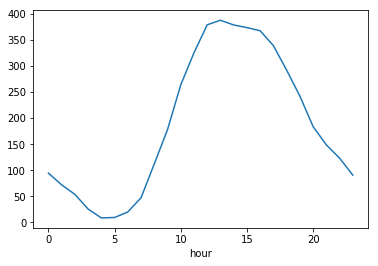

In [13]:
bikes_0.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

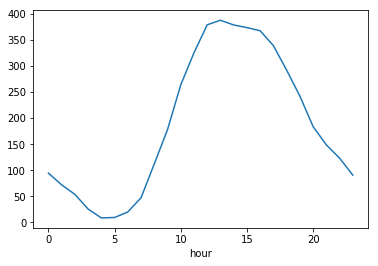

In [14]:
# hourly rental trend for "workingday=0"
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

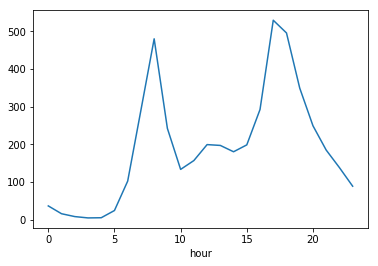

In [15]:
# hourly rental trend for "workingday=1"
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

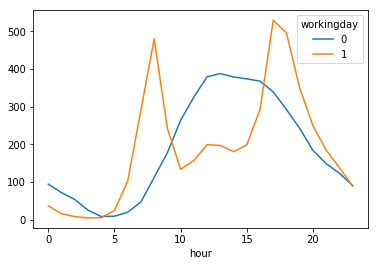

In [16]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()

Write about your findings

Las horas pico en los día laborales suelen ser las horas de salida de la casa (5 y 10 am) y salida del trabajo (3-8 pm), lo que tiene todo el sentido del mundo. mient5ras que los fines de semana, se invierte la curva hacia horas medias del día.

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Initialize
linreg = LinearRegression(fit_intercept=False)

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression

clf1 = LinearRegression()

In [20]:
clf1.fit(bikes[['hour', 'workingday']], bikes['total'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
clf1.coef_

array([10.49206282,  4.07248627])

Al estudiar una variable dicotomica, categoria, el resultado de la regresión va a ser una variable continua y no nos va a permitir segmentar la base, sino asignar una probabilidad. El entendimiento de que horas y que dias son aquellos que explican el total de horas no es claro ni contundente

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

In [22]:
bikes_izq = bikes.loc[bikes.hour>=0].copy()

In [23]:
bikes_izq.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [24]:
def error_año(bikes, hour):
    bikes['pred'] = bikes.loc[bikes.hour<hour, 'total'].mean()
    bikes.loc[bikes.hour>=hour, 'pred'] = bikes.loc[bikes.hour>=hour, 'total'].mean()
    print ((((bikes['total'] - bikes['pred'])**2).mean()) ** 0.5)
    
    

In [25]:
for hour in bikes_izq.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq, hour)


hour  0
181.13613357426559
hour  1
178.88076030483188
hour  2
175.61266024769844
hour  3
171.5350162975495
hour  4
166.57596568309665
hour  5
160.50832916137819
hour  6
154.10979930228774
hour  7
150.22560060405686
hour  8
153.86972728404965
hour  9
163.39221989024873
hour  10
165.25615391972227
hour  11
165.00286510437286
hour  12
165.84659205524616
hour  13
168.04756019190663
hour  14
169.94604099621912
hour  15
171.14521362143498
hour  16
172.47403631919644
hour  17
175.2235068708682
hour  18
179.8668827954335
hour  19
181.12705316323988
hour  20
180.44126246625746
hour  21
179.7297936918192
hour  22
179.51222338944388
hour  23
179.87454650980683


In [27]:
def error_workingday(bikes, workingday):
    bikes['pred'] = bikes.loc[bikes.workingday<workingday, 'total'].mean()
    bikes.loc[bikes.workingday>=workingday, 'pred'] = bikes.loc[bikes.workingday>=workingday, 'total'].mean()
    print ((((bikes['total'] - bikes['pred'])**2).mean()) ** 0.5)

In [28]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq, workingday)

workingday  1
181.12395921110544
workingday  0
181.13613357426559


In [29]:
bikes_izq_1 = bikes.loc[bikes.hour<7].copy()
bikes_izq_1_1 = bikes.loc[bikes.hour>=7].copy()

In [30]:
bikes_izq_1.hour.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [31]:
bikes_izq_1_1.hour.unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype=int64)

In [32]:
for hour in bikes_izq_1.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1, hour)    

hour  0
39.56714516247788
hour  1
38.46175887834954
hour  2
38.827302356307555
hour  3
39.34538405588436
hour  4
39.534113157382144
hour  5
38.30948200125475
hour  6
35.24426946227024


In [33]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1, workingday)

workingday  1
39.18093811435608
workingday  0
39.56714516247788


In [34]:
for hour in bikes_izq_1_1.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1, hour)  

hour  7
176.28835016242152
hour  8
175.9626543129351
hour  9
175.9026463917815
hour  10
176.22897287604295
hour  11
176.1454556323947
hour  12
175.84813796801208
hour  13
175.89260116453647
hour  14
175.92916682007098
hour  15
175.83965773793437
hour  16
175.82530141788737
hour  17
176.19523832330185
hour  18
175.115249088561
hour  19
170.74027110094912
hour  20
167.37168785994314
hour  21
166.69864069956597
hour  22
168.20616961120874
hour  23
171.30096203191567


In [35]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1, workingday)

workingday  1
176.2245057824691
workingday  0
176.28835016242152


In [36]:
bikes_izq_1_2 = bikes_izq_1.loc[bikes_izq_1.hour<6].copy()
bikes_izq_1_2_1 = bikes_izq_1.loc[bikes_izq_1.hour>=6].copy()

In [37]:
bikes_izq_1_2.hour.unique()
bikes_izq_1_2_1.hour.unique()

array([6], dtype=int64)

In [38]:
for hour in bikes_izq_1_2.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_2, hour)   

hour  0
30.753540668567577
hour  1
27.614237275202125
hour  2
27.46590337533093
hour  3
28.171307299972213
hour  4
29.557984864071205
hour  5
30.657024737799514


In [39]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_2, workingday)

workingday  1
27.86868086542797
workingday  0
30.753540668567577


In [40]:
for hour in bikes_izq_1_2_1.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_2_1, hour)   

hour  6
54.68514067417475


In [41]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_2_1, workingday)

workingday  1
38.85415488379482
workingday  0
54.68514067417475


In [42]:
bikes_izq_1_2_1 = bikes_izq_1_2.loc[bikes_izq_1_2.hour<2].copy()
bikes_izq_1_2_2 = bikes_izq_1_2.loc[bikes_izq_1_2.hour>=2].copy()

In [43]:
for hour in bikes_izq_1_2_1.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_2_1, hour)  

hour  0
40.538959119681785
hour  1
39.117819478677326


In [44]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_2_1, workingday)

workingday  1
30.694005806108365
workingday  0
40.538959119681785


In [45]:
bikes_izq_1_1_1 = bikes_izq_1_1.loc[bikes_izq_1_1.hour<21].copy()
bikes_izq_1_1_2 = bikes_izq_1_1.loc[bikes_izq_1_1.hour>=21].copy()

In [46]:
bikes_izq_1_1_1.hour.unique()
bikes_izq_1_1_2.hour.unique()

array([21, 22, 23], dtype=int64)

In [47]:
for hour in bikes_izq_1_1_1.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_1, hour)   

hour  7
180.02864972098826
hour  8
178.99715046718114
hour  9
180.0152330686221
hour  10
179.8185136914361
hour  11
178.3022430628963
hour  12
176.75986364527014
hour  13
176.22253234052977
hour  14
175.53287560508187
hour  15
174.04175510396522
hour  16
172.4267605458089
hour  17
173.07581303410245
hour  18
178.6648712641945
hour  19
179.97602519154125
hour  20
179.4031992036802


In [48]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_1, workingday)

workingday  1
179.9813181571363
workingday  0
180.02864972098826


In [49]:
for hour in bikes_izq_1_1_2.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_2, hour) 

hour  21
78.9719321218757
hour  22
73.39673643923476
hour  23
72.98864033487493


In [50]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_2, workingday)

workingday  1
78.59722825511945
workingday  0
78.9719321218757


In [51]:
bikes_izq_1_1_1_23 = bikes_izq_1_1_2.loc[bikes_izq_1_1_2.hour<23].copy()
bikes_izq_1_1_2_23 = bikes_izq_1_1_2.loc[bikes_izq_1_1_2.hour>=23].copy()

In [52]:
bikes_izq_1_1_1_23.hour.unique()
bikes_izq_1_1_1_23.hour.unique()

array([21, 22], dtype=int64)

In [53]:
for hour in bikes_izq_1_1_1_23.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_1_23, hour) 

hour  21
81.61307789146191
hour  22
79.15053168788128


In [54]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_1_23, workingday)

workingday  1
80.74074370646522
workingday  0
81.61307789146191


In [55]:
for hour in bikes_izq_1_1_2_23.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_2_23, hour) 

hour  23
51.5813521339401


In [56]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_2_23, workingday)

workingday  1
51.57590195076688
workingday  0
51.5813521339401


In [57]:
bikes_izq_1_1_16 = bikes_izq_1_1_1.loc[bikes_izq_1_1_1.hour<16].copy()
bikes_izq_1_1_2_16 = bikes_izq_1_1_1.loc[bikes_izq_1_1_1.hour>=16].copy()

In [58]:
bikes_izq_1_1_16.hour.unique()
bikes_izq_1_1_2_16.hour.unique()

array([16, 17, 18, 19, 20], dtype=int64)

In [59]:
for hour in bikes_izq_1_1_2_16.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_2_16, hour)

hour  16
197.5420520682468
hour  17
196.7390965483207
hour  18
194.73930688134794
hour  19
186.41275084200575
hour  20
187.65241308990824


In [60]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_2_16, workingday)

workingday  1
192.18389017185376
workingday  0
197.5420520682468


In [61]:
for hour in bikes_izq_1_1_16.hour.unique():
    print('hour ',hour)
    error_año(bikes_izq_1_1_16, hour)

hour  7
156.72440257472772
hour  8
156.34522917916382
hour  9
154.95247130836913
hour  10
155.9558851652572
hour  11
156.72292931961604
hour  12
156.51433435445483
hour  13
156.62481542315632
hour  14
156.70229619927898
hour  15
156.68163321041817


In [62]:
for workingday in [1, 0]:
    print('workingday ',workingday)
    error_workingday(bikes_izq_1_1_16, workingday)

workingday  1
155.56614105625243
workingday  0
156.72440257472772


### Nodos terminales:

In [63]:
print("1) Hour <7- hour >6 - workday 1 =  38.85415488379482")

1) Hour <7- hour >6 - workday 1 =  38.85415488379482


In [64]:
print("2) Hour <7- hour >6 - workday 0 =  54.68514067417475")

2) Hour <7- hour >6 - workday 0 =  54.68514067417475


In [65]:
print("3) Hour <7- hour <6 - hour <2 - workday 1 = 30.694005806108365")

3) Hour <7- hour <6 - hour <2 - workday 1 = 30.694005806108365


In [66]:
print("4) Hour <7- hour <6 - hour <2 - workday 0 = 40.538959119681785")

4) Hour <7- hour <6 - hour <2 - workday 0 = 40.538959119681785


In [67]:
print("5) Hour >7- hour >21 - hour >=23 = 51.5813521339401")

5) Hour >7- hour >21 - hour >=23 = 51.5813521339401


In [68]:
print("6) Hour >7- hour >21 - hour <23 - hour 22 = 79.15053168788128")

6) Hour >7- hour >21 - hour <23 - hour 22 = 79.15053168788128


# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

In [69]:
# define X and y
feature_cols = ['hour', 'workingday']
X = bikes[feature_cols]
y = bikes.total

In [70]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [71]:
import numpy as np
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

105.19244713068338

In [72]:

# list of values to try
max_depth_range = range(1, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0,0.5,'RMSE (lower is better)')

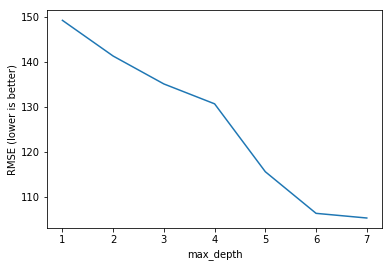

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [74]:
reereg = DecisionTreeRegressor(max_depth=7,random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

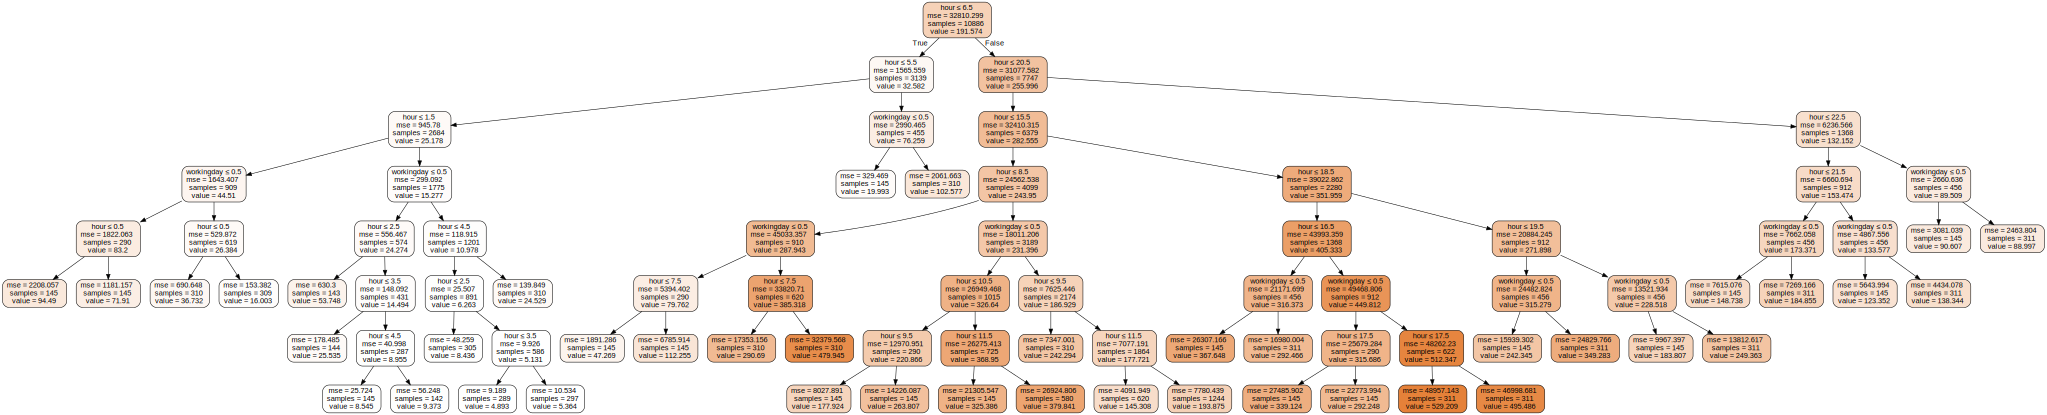

In [75]:

# create a Graphviz file
import graphviz 
from sklearn.tree import export_graphviz
a= export_graphviz(treereg, out_file=None , feature_names=feature_cols,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(a)  
graph